# import module


# Confusion Matrix, Oversampling

Confusion matrix
- Hyperparameter:epoch=5, batch_size=256, lr=0.0001
- optimizer: Adam
- Seed:42


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler, Subset
from PIL import Image
from dataset import MaskData, transform, TestDataset
import model
import random
import GPUtil

In [2]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    #os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [3]:
DEA_PATH = 'DEA'
if not os.path.exists(DEA_PATH):
    os.mkdir(DEA_PATH)

# Hypermarameter

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

EPOCHS = 3
BATCH_SIZE = 256
LEARNING_RATE = 0.0001

cuda


# Data Load and Model define

In [5]:
trian_transform = transform(train=True)

mask_data = MaskData(root='../../input/data',transform=trian_transform, train=True, class_by='mask')
gender_data = MaskData(root='../../input/data',transform=trian_transform, train=True, class_by='gender')
age_data = MaskData(root='../../input/data',transform=trian_transform, train=True, class_by='age')

       id  gender   race  age                    path
0  003364  female  Asian   19  003364_female_Asian_19
1  003185  female  Asian   19  003185_female_Asian_19
2  003044  female  Asian   20  003044_female_Asian_20
3  001549  female  Asian   60  001549_female_Asian_60
4  003196  female  Asian   20  003196_female_Asian_20
         id  gender   race  age                    path
0    006639    male  Asian   19    006639_male_Asian_19
1    001368  female  Asian   22  001368_female_Asian_22
2    005425  female  Asian   40  005425_female_Asian_40
3  001131-1    male  Asian   22  001131-1_male_Asian_22
4    006210    male  Asian   19    006210_male_Asian_19
       id  gender   race  age                    path
0  003853  female  Asian   57  003853_female_Asian_57
1  000302  female  Asian   56  000302_female_Asian_56
2  003821    male  Asian   38    003821_male_Asian_38
3  001436    male  Asian   57    001436_male_Asian_57
4  004442    male  Asian   40    004442_male_Asian_40


## Split data set before make shuffle!

In [6]:
n_test = int(len(mask_data)*0.2) # 0.2 means => train 80%, test 20%
n_train= len(mask_data) - n_test
n_train = [i for i in range(n_train)]
n_test= [i for i in range(len(n_train), len(mask_data))]

mask_train_set = Subset(mask_data, n_train)
mask_val_set = Subset(mask_data, n_test)
gender_train_set = Subset(gender_data, n_train)
gender_val_set = Subset(gender_data, n_test)
age_train_set = Subset(age_data, n_train)
age_val_set = Subset(age_data, n_test)


## and then make each set a loader

In [7]:
mask_train_loader = DataLoader(mask_train_set, batch_size=BATCH_SIZE, shuffle=True)
mask_val_loader = DataLoader(mask_val_set, batch_size=BATCH_SIZE, shuffle=True)

gender_train_loader = DataLoader(gender_train_set, batch_size=BATCH_SIZE, shuffle=True)
gender_val_loader = DataLoader(gender_val_set, batch_size=BATCH_SIZE, shuffle=True)

age_train_loader = DataLoader(age_train_set, batch_size=BATCH_SIZE, shuffle=True)
age_val_loader = DataLoader(age_val_set, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
mask_model = model.resnet18(3).to(device)
gender_model = model.resnet18(2).to(device)
age_model = model.resnet18(3).to(device)

# Optimizer, train, eval func define

In [9]:
loss_fn = torch.nn.CrossEntropyLoss()
mask_optimizer = torch.optim.Adam(mask_model.parameters(), lr = LEARNING_RATE)
gender_optimizer = torch.optim.Adam(gender_model.parameters(), lr = LEARNING_RATE)
age_optimizer = torch.optim.Adam(age_model.parameters(), lr = LEARNING_RATE)

In [10]:
dataloaders = {
    "mask_train" : mask_train_loader,
    "mask_val" : mask_val_loader,
    "gender_train": gender_train_loader,
    "gender_val": gender_val_loader,
    "age_train": age_train_loader,
    "age_val": age_val_loader
}

In [11]:
def train(model, train_loader, optimizer, loss_fn, log_interval=10):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(f"[{batch_idx * len(image)}/{len(train_loader.dataset)} ({100.*batch_idx/len(train_loader):.0f}%)] train loss:{loss.item():.3f}")

## val funcition will get loss, acc from test set and make tensor(like list) for confusion matrix

In [12]:
def val(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    preds = torch.tensor([]) # for confusion matrix
    preds = preds.to(device)
    targets = torch.tensor([]) # for confusion matrix
    targets = targets.to(device)
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(device)
            label = label.to(device)
            output = model(image)
            test_loss += loss_fn(output, label).item()
            pred = output.max(1, keepdim = True)[1]
            correct += pred.eq(label.view_as(pred)).sum().item()
            
            preds = torch.cat((preds, pred), dim=0)
            targets = torch.cat((targets, label), dim=0)
            
    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)
    return test_loss, test_acc, preds, targets

# Learning

In [13]:
all_mask_preds = None # for confusion matrix
all_mask_targets = None
for epoch in range(1, EPOCHS +1):

    train(mask_model, dataloaders['mask_train'], mask_optimizer, loss_fn)
    test_loss, test_acc, preds, targets = val(mask_model, dataloaders['mask_val'])
    print(f'\n[epoch:{epoch}] \tTest loss:{test_loss:.4f}, \tTest acc:{test_acc:.2f}%')
    if epoch == EPOCHS: # last epoch make list for confusion matrix
        all_mask_preds= preds
        all_mask_targets = targets



[0/15120 (0%)] train loss:1.115
[2560/15120 (17%)] train loss:0.131
[5120/15120 (33%)] train loss:0.059
[7680/15120 (50%)] train loss:0.055
[10240/15120 (67%)] train loss:0.012
[12800/15120 (83%)] train loss:0.008

[epoch:1] 	Test loss:0.0004, 	Test acc:96.46%
[0/15120 (0%)] train loss:0.008
[2560/15120 (17%)] train loss:0.001
[5120/15120 (33%)] train loss:0.001
[7680/15120 (50%)] train loss:0.028
[10240/15120 (67%)] train loss:0.017
[12800/15120 (83%)] train loss:0.005

[epoch:2] 	Test loss:0.0001, 	Test acc:99.31%
[0/15120 (0%)] train loss:0.001
[2560/15120 (17%)] train loss:0.002
[5120/15120 (33%)] train loss:0.001
[7680/15120 (50%)] train loss:0.001
[10240/15120 (67%)] train loss:0.001
[12800/15120 (83%)] train loss:0.000

[epoch:3] 	Test loss:0.0001, 	Test acc:99.37%


In [14]:
torch.save(mask_model, os.path.join(DEA_PATH,'mask_model.pt'))

In [15]:
all_gender_preds = None
all_gender_preds = None

for epoch in range(1, EPOCHS +1):
    train(gender_model, dataloaders['gender_train'], gender_optimizer, loss_fn)
    test_loss, test_acc, preds, targets = val(gender_model, dataloaders['gender_val'])
    print(f'\n[epoch:{epoch}] \tTest loss:{test_loss:.4f}, \tTest acc:{test_acc:.2f}%')
    if epoch == EPOCHS:
        all_gender_preds = preds
        all_gender_targets = targets


[0/15120 (0%)] train loss:0.914
[2560/15120 (17%)] train loss:0.196
[5120/15120 (33%)] train loss:0.116
[7680/15120 (50%)] train loss:0.108
[10240/15120 (67%)] train loss:0.064
[12800/15120 (83%)] train loss:0.064

[epoch:1] 	Test loss:0.0013, 	Test acc:86.06%
[0/15120 (0%)] train loss:0.018
[2560/15120 (17%)] train loss:0.030
[5120/15120 (33%)] train loss:0.010
[7680/15120 (50%)] train loss:0.015
[10240/15120 (67%)] train loss:0.025
[12800/15120 (83%)] train loss:0.022

[epoch:2] 	Test loss:0.0005, 	Test acc:95.63%
[0/15120 (0%)] train loss:0.008
[2560/15120 (17%)] train loss:0.006
[5120/15120 (33%)] train loss:0.012
[7680/15120 (50%)] train loss:0.015
[10240/15120 (67%)] train loss:0.011
[12800/15120 (83%)] train loss:0.003

[epoch:3] 	Test loss:0.0006, 	Test acc:95.98%


In [16]:
torch.save(gender_model, os.path.join(DEA_PATH,'gender_model.pt'))

In [17]:
all_age_preds = None
all_age_preds = None

for epoch in range(1, EPOCHS +1):
    train(age_model, dataloaders['age_train'], age_optimizer, loss_fn)
    test_loss, test_acc,preds, targets = val(age_model, dataloaders['age_val'])
    print(f'\n[epoch:{epoch}] \tTest loss:{test_loss:.4f}, \tTest acc:{test_acc:.2f}%')
    if epoch == EPOCHS:
        all_age_preds = preds
        all_age_targets = targets

[0/15120 (0%)] train loss:2.283
[2560/15120 (17%)] train loss:0.485
[5120/15120 (33%)] train loss:0.251
[7680/15120 (50%)] train loss:0.314
[10240/15120 (67%)] train loss:0.232
[12800/15120 (83%)] train loss:0.139

[epoch:1] 	Test loss:0.0023, 	Test acc:77.86%
[0/15120 (0%)] train loss:0.139
[2560/15120 (17%)] train loss:0.103
[5120/15120 (33%)] train loss:0.081
[7680/15120 (50%)] train loss:0.065
[10240/15120 (67%)] train loss:0.051
[12800/15120 (83%)] train loss:0.035

[epoch:2] 	Test loss:0.0015, 	Test acc:88.41%
[0/15120 (0%)] train loss:0.012
[2560/15120 (17%)] train loss:0.021
[5120/15120 (33%)] train loss:0.015
[7680/15120 (50%)] train loss:0.026
[10240/15120 (67%)] train loss:0.009
[12800/15120 (83%)] train loss:0.011

[epoch:3] 	Test loss:0.0015, 	Test acc:88.76%


In [18]:
torch.save(age_model, os.path.join(DEA_PATH,'age_model.pt'))

# Confusion Matrix 

In [19]:
print(all_mask_preds.to(torch.int64).reshape(-1))
print(all_mask_targets.to(torch.int64))

tensor([0, 1, 1,  ..., 0, 0, 0], device='cuda:0')
tensor([0, 1, 1,  ..., 0, 0, 0], device='cuda:0')


In [20]:
def confusion_matrix(all_preds, all_targets, classes):
    stacked = torch.stack((all_targets, all_preds), dim=1)
    cmt = torch.zeros(classes, classes, dtype=torch.int64)
    for p in stacked:
        tl, pl = p.tolist()
        cmt[tl, pl] = cmt[tl, pl] + 1
    
    return cmt

In [21]:
mask_cmt = confusion_matrix(all_mask_preds.to(torch.int64).reshape(-1), all_mask_targets.to(torch.int64), 3)
#all_mask_preds = torch([0,1,2, ... 5,6,7])
#all_mask_target = torch([0,1,2, ... 5,6,7])

In [22]:
print(mask_cmt)

tensor([[2697,    3,    0],
        [  15,  521,    4],
        [   0,    2,  538]])


In [23]:
gender_cmt = confusion_matrix(all_gender_preds.to(torch.int64).reshape(-1), all_gender_targets.to(torch.int64), 2)

In [24]:
age_cmt = confusion_matrix(all_age_preds.to(torch.int64).reshape(-1), all_age_targets.to(torch.int64), 3)

In [25]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure(figsize=(18,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


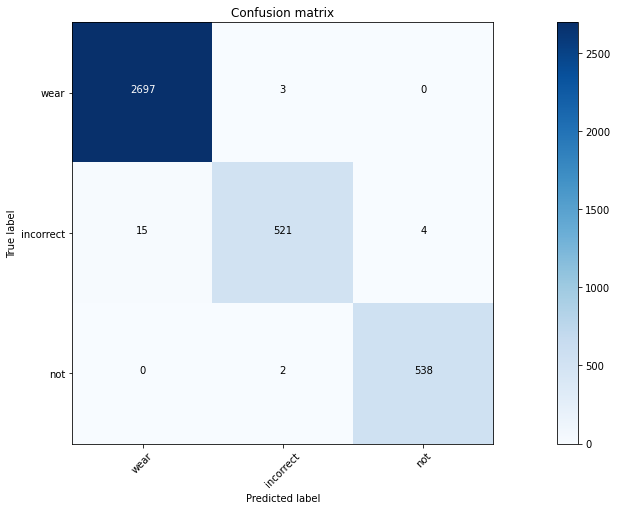

In [26]:
plot_confusion_matrix(mask_cmt, ['wear', 'incorrect', 'not'])

Confusion matrix, without normalization


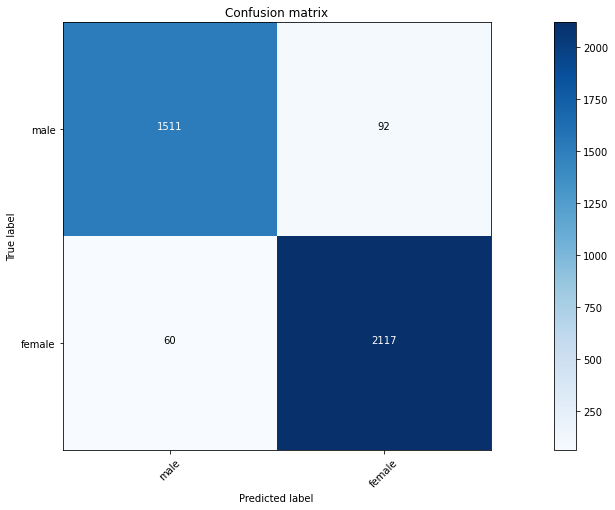

In [27]:
plot_confusion_matrix(gender_cmt, ['male','female'])

Confusion matrix, without normalization


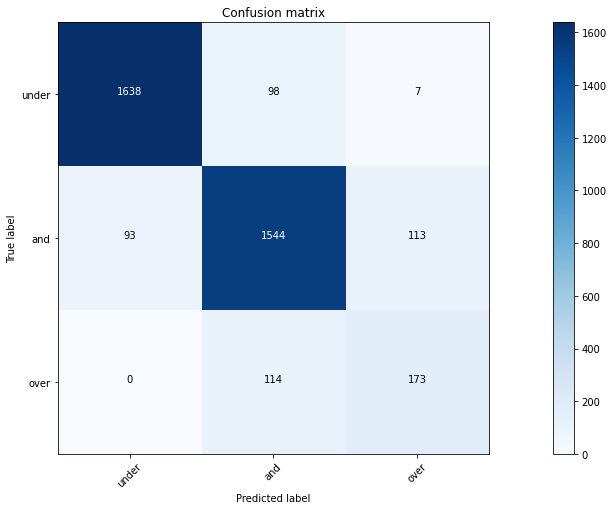

In [28]:
plot_confusion_matrix(age_cmt, ['under','and','over'])

# Inference

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
from PIL import Image
from dataset import MaskData, transform, TestDataset
import model

import GPUtil
DEA_PATH = 'DEA'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
test_transform = transform()
test_dataset = TestDataset(root='../../input/data', transform=test_transform)
test_loader = DataLoader(test_dataset, shuffle=False)

In [3]:
mask_model = torch.load(os.path.join(DEA_PATH,'mask_model.pt')).to(device)
gender_model = torch.load(os.path.join(DEA_PATH,'gender_model.pt')).to(device)
age_model = torch.load(os.path.join(DEA_PATH,'age_model.pt')).to(device)

In [4]:
class_dict = {}
class_mask = ['waer','incorrect','not']
class_gender =['male','female']
class_age =['under','and','over']

i = 0
for mask in class_mask:
    for gender in class_gender:
        for age in class_age:
            cls = '-'.join([mask, gender, age])
            class_dict[cls] = i
            #print("-".join([mask,gender,age]))
            i+= 1
print(class_dict)

{'waer-male-under': 0, 'waer-male-and': 1, 'waer-male-over': 2, 'waer-female-under': 3, 'waer-female-and': 4, 'waer-female-over': 5, 'incorrect-male-under': 6, 'incorrect-male-and': 7, 'incorrect-male-over': 8, 'incorrect-female-under': 9, 'incorrect-female-and': 10, 'incorrect-female-over': 11, 'not-male-under': 12, 'not-male-and': 13, 'not-male-over': 14, 'not-female-under': 15, 'not-female-and': 16, 'not-female-over': 17}


In [5]:
# def val(mask_mode, gender_model, age_model, test_loader):
    
#     all_predictions = []
#     for images in test_loader:
#         with torch.no_grad():
#             images = images.to(device)
#             pred = model(images)
#             pred = pred.argmax(dim=-1)
#             all_predictions.extend(pred.cpu().numpy())
#     return all_predictions

def val(mask_model, gender_model, age_model, test_loader):
    all_predictions = []
    i = 0
    for image in test_loader:
        target = []
        with torch.no_grad():
            image = image.to(device)
            
            mask_pred = mask_model(image)
            mask_pred = mask_pred.argmax(dim=-1)
            
            gender_pred = gender_model(image)
            gender_pred = gender_pred.argmax(dim=-1)
            
            age_pred = age_model(image)
            age_pred = age_pred.argmax(dim=-1)
            
            target.append(class_mask[mask_pred.item()])
            target.append(class_gender[gender_pred.item()])
            target.append(class_age[age_pred.item()])
            target = '-'.join(target)
            
            #print(mask_pred.item(), gender_pred.item(), age_pred.item(), target, class_dict[target])
            all_predictions.append(class_dict[target])
            
    return all_predictions

In [6]:
def save_result(all_predictions, test_dir):
    submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
    submission['ans'] = all_predictions
    submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
    print('test inference is done!')

In [7]:
all_predictions = val(mask_model, gender_model, age_model, test_loader)

2 0 0 not-male-under 12
[12]
0 0 1 waer-male-and 1
[12, 1]
2 0 1 not-male-and 13
[12, 1, 13]
2 0 2 not-male-over 14
[12, 1, 13, 14]
2 0 0 not-male-under 12
[12, 1, 13, 14, 12]


In [8]:
import os
import pandas as pd
save_result(all_predictions, '../../input/data/eval')

test inference is done!


In [22]:
print(all_predictions)

None
